__This project is for optimizing focusing parameter__

Focusing parameter,  $F(\xi, \Phi) = \int\limits_{-1}^{1} \dfrac{\sqrt{\xi} \exp{(i \Phi \frac{l}{2})} }{1 - i\xi l} dl  $ This is from equation (27), paper:  [Optimal collinear Gaussian beams for spontaneous parametric down-conversion](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.053805), by Ryan Bennink

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from joblib import Parallel, delayed        # import joblib for parallel computation
from tqdm import tqdm                       # import tqdm to show progress


Define the integrand function:

$ \dfrac{\sqrt{\xi} \exp{(i \Phi \frac{l}{2})} }{1 - i\xi l}  $


In [2]:

def intgrnd(ξ, Φ, l):
    numerator = np.sqrt(ξ) * np.exp(1j * Φ * l/2)
    denominator = 1 - 1j * ξ * l
    return numerator / denominator
    

Integration using `quad()` from scipy: </br>
(output is a complex number)

In [3]:

def F(ξ, Φ):
    integral_real, _ = quad(lambda l: intgrnd(ξ, Φ, l).real, -1, 1)
    integral_imag, _ = quad(lambda l: intgrnd(ξ, Φ, l).imag, -1, 1)
    return integral_real + 1j * integral_imag
    

__Meshgridding for $\xi$, $\Phi$ and $F$__ 

In [4]:

pixel            = 1000                                   #10000
ξ_range          = np.linspace(0.05, 200, pixel)          
Φ_range          = np.linspace(-7*np.pi, 3*np.pi, pixel)  
ξ_grid, Φ_grid   = np.meshgrid(ξ_range, Φ_range)
F_grid           = np.zeros_like(ξ_grid, dtype=float)     #ξ_grid and Φ_grid has same dimension, either of them is fine
    

__Preparing to use `joblib` and `tqdm` by flattening the indices__

In [5]:
     
indices = []
for i in range(ξ_grid.shape[0]):                            #   output be like: indices = [(0, 0), (0, 1), (0, 2),... (pixel, pixel)]
    for j in range(ξ_grid.shape[1]):
        indices.append((i, j))


                                                             
indices_tqdm = tqdm(indices, desc="Computing |F(ξ, φ)|")    # regular list of indices to tqdm list of indices

def F_points(i, j):                                         #this is a function to evaluate the empty values of F_grid
    return np.abs( F(ξ_grid[i, j], Φ_grid[i, j]) )

result  = Parallel(n_jobs=-1,
                  verbose=0, 
                  backend='loky')(
    delayed(F_points)(i, j) for i, j in indices_tqdm
    )

F_grid  = np.array(result).reshape(ξ_grid.shape)

np.save("F_grid_1k.npy", F_grid)


Computing |F(ξ, φ)|: 100%|████████████████████████████| 1000000/1000000 [02:25<00:00, 6850.49it/s]


__Plotting__ </br>
Setting up the display in custom font and pixel

In [10]:

from scipy.ndimage import zoom
import matplotlib.font_manager as fm
from IPython.display import set_matplotlib_formats
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

regular_path = r'E:\VirtualEnvironment\.venv\Fonts\Futura-Regular.ttf'
bold_path    = r'E:\VirtualEnvironment\.venv\Fonts\Fontin-Bold.ttf'
italic_path  = r'E:\VirtualEnvironment\.venv\Fonts\Minion-It.otf'

regular_font = fm.FontProperties(fname=regular_path)
bold_font    = fm.FontProperties(fname=bold_path, weight='bold')
italic_font  = fm.FontProperties(fname=italic_path, style='italic')


__Customizing the plot__

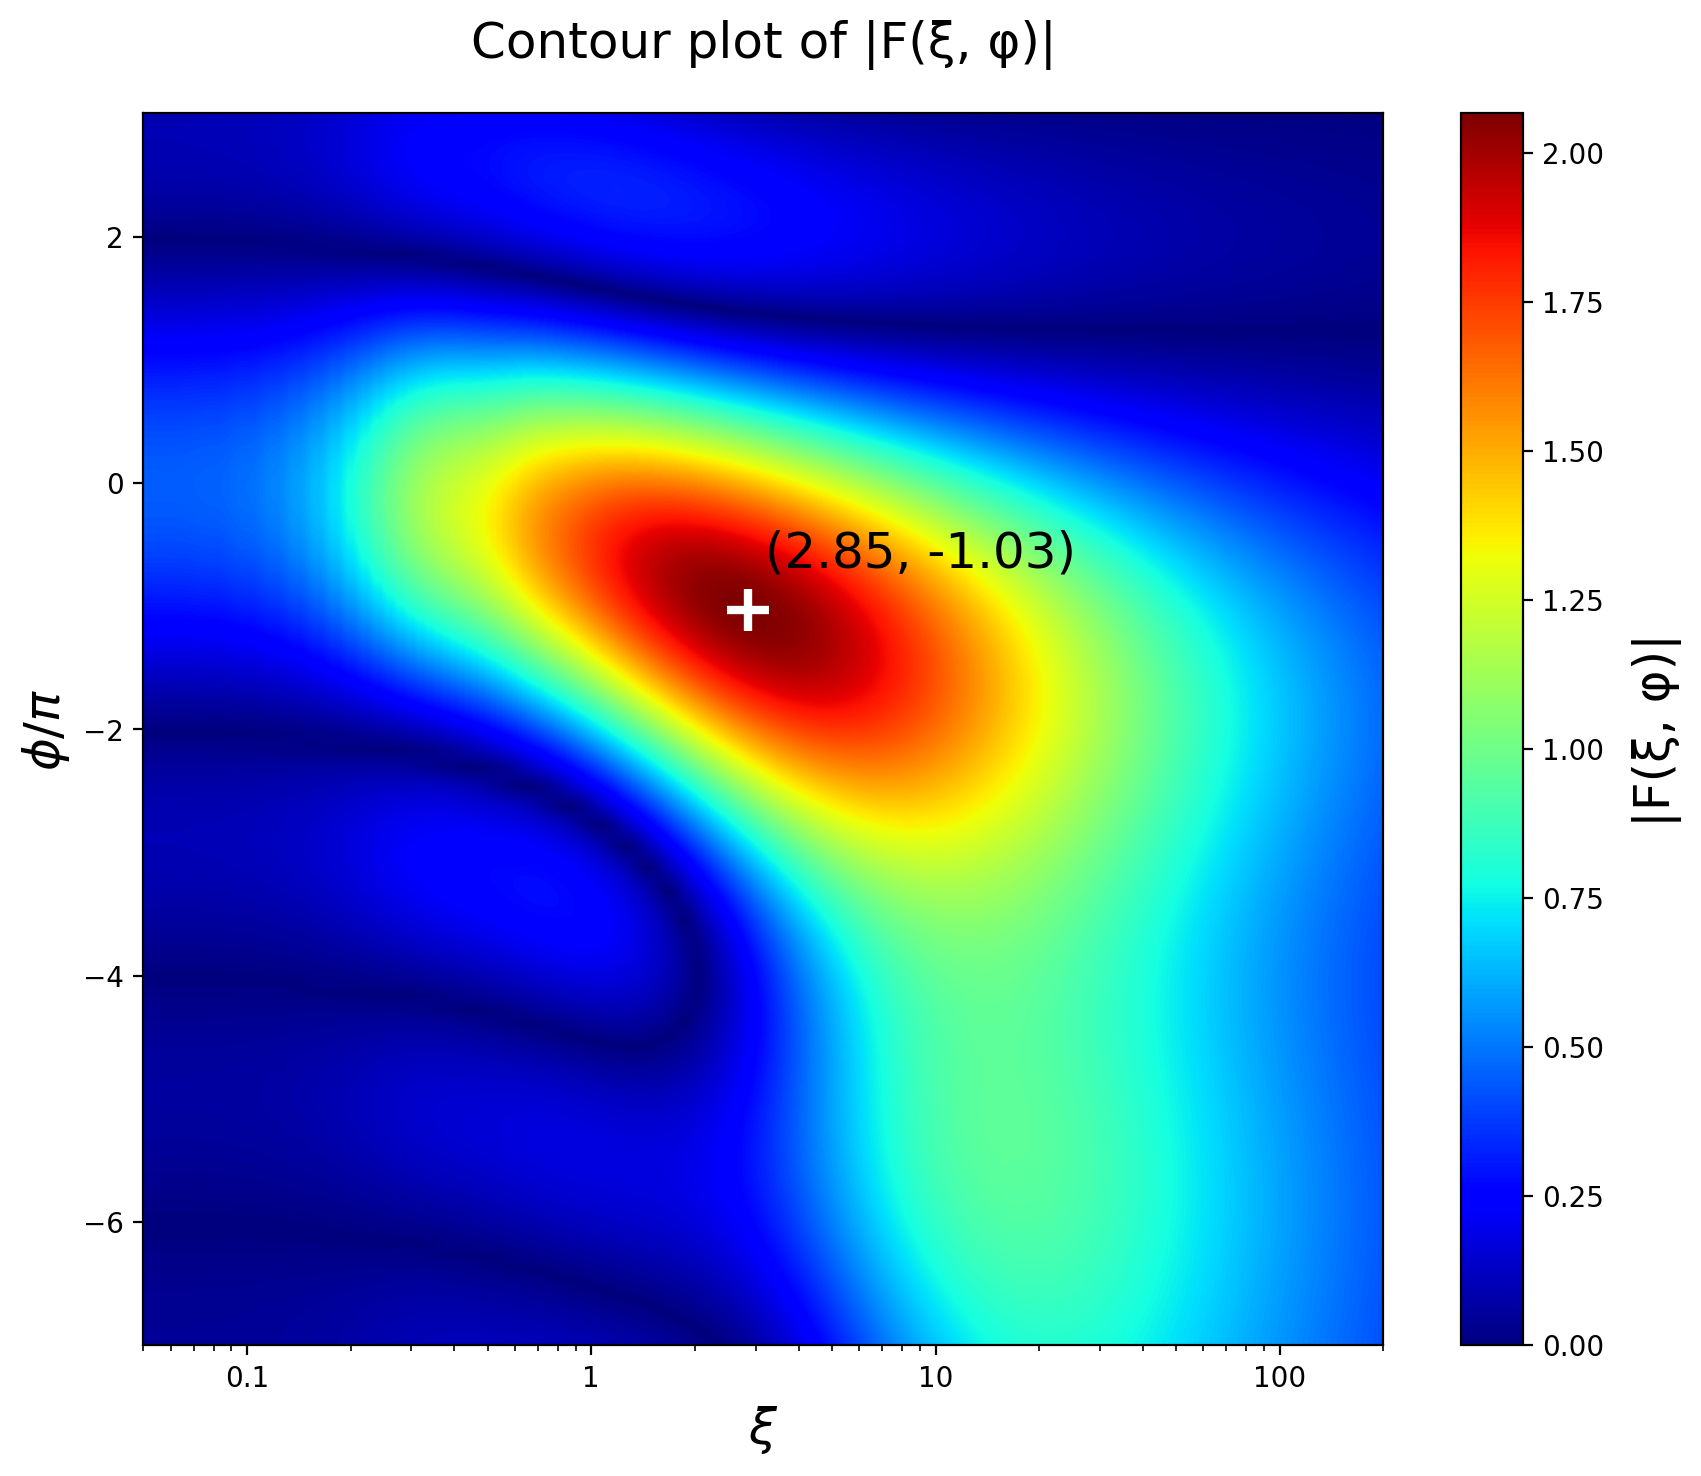

In [21]:

data = np.load("F_grid_1k.npy")
data_smooth = zoom(data, 10)

ξ_range_smooth = np.linspace(ξ_range.min(), ξ_range.max(), data_smooth.shape[1])
Φ_range_smooth = np.linspace((Φ_range/np.pi).min(), (Φ_range/np.pi).max(), data_smooth.shape[0])

plt.figure(figsize=(10, 8))

plt.imshow(data_smooth, 
           extent=[ξ_range.min(), ξ_range.max(), (Φ_range/np.pi).min(), (Φ_range/np.pi).max()],
           origin='lower', 
           aspect='auto', 
           cmap='jet') 

plt.xscale('log')
plt.xlabel(r'$\xi$', fontsize=18)
plt.xticks([0.1, 1, 10, 100], ['0.1', '1', '10', '100'])
plt.ylabel(r'$\phi / \pi$', fontsize=18)
plt.title('Contour plot of |F(ξ, φ)|', fontsize=18, pad=20)

cbar = plt.colorbar()  # Create the colorbar first
cbar.set_label('|F(ξ, φ)|', fontsize=18, labelpad=10)  # Set the label with the desired font size

#=============================================================================================================================#
#                                 finding the maximum F values and corresponding ξ and Φ values                               #
#=============================================================================================================================#

max_loc_1D = np.argmax(data, axis=None)                     #location of the index with max F value
max_idx    = np.unravel_index( max_loc_1D, data.shape)      #corresponding x and y index values
max_ξ      = ξ_range[max_idx[1]]                            # corresponding xi value
max_Φ      = (Φ_range/np.pi)[max_idx[0]]                            # corresponding phi/pi value

# Plot a white '+' at the maximum value position
plt.plot(max_ξ, max_Φ, 'w+', markersize=15, markeredgewidth=3)
plt.text(max_ξ+0.35, max_Φ+0.35, f'({max_ξ:.2f}, {max_Φ:.2f})', color='black', fontsize=18, ha='left')
plt.savefig("focus.png")
plt.show()
